#### Loading the images

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from skimage.feature import hog
from scipy.ndimage.measurements import label
%matplotlib inline


In [2]:
#----------------------------------------------
# Get Spatial binning return 32*32 features
#----------------------------------------------

def spatial_bin_feat(img,color_space = 'RGB',size = (32,32)):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
            feature_img2 = feature_img[:,:,2]
        elif color_space == 'HLS':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
            feature_img1 = feature_img[:,:,0]
            feature_img2 = feature_img[:,:,2]
#             plt.title(feature_img[:,:,1].shape)
#             plt.imshow(feature_img[:,:,1],cmap = 'gray')
        elif color_space == 'YUV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
            feature_img2 = feature_img[:,:,0]
    else:
        feature_img = np.copy(img)
#     print(feature_img.shape)
    features = cv2.resize(feature_img2,size).ravel()
   # print(features.shape)
    return features

#----------------------------------------------
# Get Color histogram features
#----------------------------------------------
def color_hist(img,nbins =32,bins_range = (0,256)):
    # histogram if RGB channels
    img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    h_hist = np.histogram(img[:,:,0],bins = nbins,range = bins_range)
    l_hist = np.histogram(img[:,:,1],bins = nbins,range = bins_range)
    s_hist = np.histogram(img[:,:,2],bins = nbins,range = bins_range)
    
    h_features = np.concatenate((h_hist[0],l_hist[0],s_hist[0]))
#     h_features = np.concatenate((rhist[0],bhist[0]))
    return h_features

#----------------------------------------------
# Get HOG features
#----------------------------------------------
def hog_features(img,orient,pix_per_cell,cell_per_block,vis = False ,feature_vec = True):
    ret_list = hog(img,orientations = orient ,pixels_per_cell = (pix_per_cell,pix_per_cell),cells_per_block = (cell_per_block,cell_per_block),block_norm= 'L2-Hys', transform_sqrt=False, visualise= vis, feature_vector= feature_vec)
    # name returns explicitly
    hog_features = ret_list[0]
    if vis:
        hog_image = ret_list[1]
        return hog_features.ravel(), hog_image
    else:
        return hog_features.ravel()
    
#----------------------------------------------
# Get Combined features
#----------------------------------------------
def get_all_features(t_img):
    sp_size = (20,20)
    sb_features = spatial_bin_feat(t_img,'YUV',sp_size)
    
#     hist_features = color_hist(t_img)
    
    hls_img = cv2.cvtColor(t_img,cv2.COLOR_RGB2HLS)
    s_img = hls_img[:,:,2]
    sh_features, shog_image = hog_features(s_img, orient= 10, 
                            pix_per_cell= 16, cell_per_block= 2, 
                            vis=True, feature_vec=False)
    
    yuv_img = cv2.cvtColor(t_img,cv2.COLOR_RGB2YUV)
    y_img = yuv_img[:,:,0]
    yh_features, yhog_image = hog_features(y_img, orient= 10, 
                            pix_per_cell= 16, cell_per_block= 2, 
                            vis=True, feature_vec=False)
    comb_feature = np.concatenate((sh_features,yh_features,sb_features))
#     comb_feature = np.concatenate((hist_features,h_features))
    #print(len(comb_feature))
    return comb_feature

In [3]:
non_vehicle_paths = ["non-vehicles/Extras/*.png", "non-vehicles/GTI/*.png"]

vehicle_paths = ["vehicles/GTI_Far/*.png", "vehicles/GTI_Left/*.png", "vehicles/GTI_Right/*.png",
                    "vehicles/GTI_MiddleClose/*.png", "vehicles/KITTI_extracted/*.png"]

non_vehicle_filenames = []
vehicle_filenames = []

for path in non_vehicle_paths:
    non_vehicle_filenames += glob.glob(path)
    
for path in vehicle_paths:
    vehicle_filenames += glob.glob(path)
    
# print(non_vehicle_filenames[0])
# print(vehicle_filenames[0])

#Vehicles : 8792 #Non-Vehicles: 8968
1120


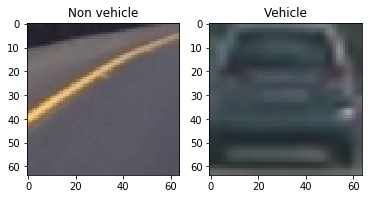

In [4]:
print("#Vehicles :",len(vehicle_filenames),"#Non-Vehicles:",len(non_vehicle_filenames))
## #Vehicles : 8792 #Non-Vehicles: 8968

nv_img = cv2.imread(non_vehicle_filenames[10])
nv_img = cv2.cvtColor(nv_img,cv2.COLOR_BGR2RGB)
v_img = cv2.imread(vehicle_filenames[10])
v_img = cv2.cvtColor(v_img,cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.title("Non vehicle")
plt.imshow(nv_img)
plt.subplot(1,2,2)
plt.title("Vehicle")
plt.imshow(v_img)

t = get_all_features(v_img)
print(len(t))

In [5]:
# print(np.max(nv_img),np.min(nv_img)) #0.8117647 0.015686275
# print(v_img.shape) #(64, 64, 3)
all_img_features = []
for idx in range(len(vehicle_filenames)):
    # to get all the feature
    v_img = cv2.imread(vehicle_filenames[idx])
    v_img = cv2.cvtColor(v_img,cv2.COLOR_BGR2RGB)
    img_feature = get_all_features(v_img)
    img_feature = img_feature.tolist()
    all_img_features.append(img_feature)
# print(all_img_features.size)
print(len(all_img_features))

for nv_idx in range(len(non_vehicle_filenames)):
    # to get all the feature
    nv_img = cv2.imread(non_vehicle_filenames[nv_idx])
    nv_img = cv2.cvtColor(nv_img,cv2.COLOR_BGR2RGB)
    img_feature = get_all_features(nv_img)
    img_feature = img_feature.tolist()
    all_img_features.append(img_feature)
    
# one hot encoded vectors is_car = 1 if its a car
is_car = np.ones(len(vehicle_filenames))
is_car = is_car.tolist()
# print(len(is_car))
non_car = np.zeros(len(non_vehicle_filenames))
non_car = non_car.tolist()
is_car += non_car
print(len(is_car))

8792
17760


In [6]:
# writing feature vectors in pickle file
import pickle
output_f = open('features_t1.pkl','wb')
output_h = open('onehot_t1.pkl','wb')
pickle.dump(all_img_features,output_f)
pickle.dump(is_car,output_h)

In [7]:
import pickle
f_file = open('features_t1.pkl','rb')
h_file = open('onehot_t1.pkl','rb')
X_pkl = pickle.load(f_file)
Y_pkl = pickle.load(h_file)
# print(len(X_train)) #17760
# print(len(Y_train)) #17760
X = np.vstack(X_pkl).astype(np.float64)
y = np.hstack(Y_pkl)

In [8]:
#-----------------------------
# Training the SVN model
#-----------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC

def train_model(X,y):
    rand_state = np.random.randint(0,100)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = rand_state)

    # fit a per column scalar
    X_scalar = StandardScaler().fit(X_train)
    #Apply the scalar  to X
    scaled_X_train = X_scalar.transform(X_train)
    scaled_X_test = X_scalar.transform(X_test)
    #print(scaled_X_test)

    svc = SVC(kernel = "rbf")
    svc.fit(scaled_X_train,y_train)
    return svc,X_scalar,scaled_X_train,scaled_X_test,y_test


C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
import time
start_time = time.time()
svc,X_scalar,_,scaled_X_test,y_test = train_model(X,y)
print("--- %s seconds ---" % (time.time() - start_time))
# print("Train Accuracy :",svc.score(scaled_X_train,y_train))
# # Linear SVC
# # Train Accuracy : 0.9985923423423423
# # SVC with linear kernel
# # Train Accuracy : 0.9995777027027027
# # SVC with rbf kernel
# # Train Accuracy : 0.9773367117117117
print("Test Accuracy :",svc.score(scaled_X_test,y_test))
# Linear SVC
# Test Accuracy : 0.9293355855855856
# SVC with linear kernel
# Test Accuracy : 0.928490990990991
# SVC with rbf kernel
# Test Accuracy : 0.9710022522522522

--- 63.739924907684326 seconds ---
Test Accuracy : 0.9817004504504504


In [10]:
# #-----------------------------------
# #   Predicting (for Y=Testing)
# #-----------------------------------
# print(len(scaled_X_test[0]))
t1 = time.time()
svc.predict(scaled_X_test[0:200])
print(time.time()- t1) #2.0156702995300293


# # ridx = np.random.randint(0,len(vehicle_filenames))
# ridx = np.random.randint(0,len(non_vehicle_filenames))
# print(ridx,len(vehicle_filenames))
# # pred_img = plt.imread(vehicle_filenames[ridx])
# pred_img = plt.imread(non_vehicle_filenames[ridx])
# img_feat = get_all_features(pred_img)
# scaled_img_feat = X_scalar.transform(img_feat.reshape(1,-1))

# p_start_time = time.time()
# ret = svc.predict(scaled_img_feat)
# print("--- %s seconds ---" % (time.time() - p_start_time))
# print(ret)
# # for false images

# if ret == 1.0:
#     plt.imshow( plt.imread(non_vehicle_filenames[ridx]),cmap = 'gray')#4534 

0.7375311851501465


In [11]:
# a = np.array([1,23,44])
# a = a.tolist()
# print(type(a))
# x = []
# t = [1,2]
# p = [1,3]
# x.append(t)
# x.append(p)
# print(x)

In [12]:
#--------------------------------------------------
# Windowing Functions
#--------------------------------------------------
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=1):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def all_windows(img):
    test_img = np.copy(img)
    x_start_stop=[640,860]
    y_start_stop=[380, 460]
    w1 = slide_window(test_img, x_start_stop, y_start_stop,xy_window=(64, 64), xy_overlap=(0.7, 0.7))
    x_start_stop=[570,1050]
    y_start_stop=[400, 490]
    w1.extend(slide_window(test_img, x_start_stop, y_start_stop,xy_window=(80, 80), xy_overlap=(0.8, 0.8)))
    y_start_stop=[370, 540]
    
    x_start_stop=[570,1280]
    w1.extend(slide_window(test_img, x_start_stop, y_start_stop,xy_window=(100, 100), xy_overlap=(0.65, 0.65)))
    y_start_stop=[410, 590]
    w1.extend(slide_window(test_img, x_start_stop, y_start_stop,xy_window=(120, 120), xy_overlap=(0.7, 0.7)))
    w1.extend(slide_window(test_img, x_start_stop, y_start_stop,xy_window=(140, 140), xy_overlap=(0.6, 0.7)))
    windows_img = draw_boxes(test_img,w1)
    #plt.imshow(windows_img)
    plt.imsave('windowsNew.jpg',windows_img)
    return w1

# passed args source image,Classifier object,all windows
def search_window_obj(img,svc,windows):
    car_windows = []
#     count = 0
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = get_all_features(test_img)
        scaled_feature = X_scalar.transform(features.reshape(1,-1))
        # predict using classifier
        prediction = svc.predict(scaled_feature)
        
        if prediction == 1:
#             count+=1
            car_windows.append(window)
#     print('matched windows:',count)
    return car_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels,thrshold):
    # Iterate through all detected cars
    nboxes = 0
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzerox) - np.min(nonzerox)) > thrshold[0]) & ((np.max(nonzeroy) - np.min(nonzeroy)) > thrshold[1]):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            nboxes+=1
    # Return the image
#     print(nboxes)
    return img

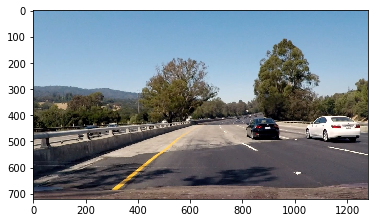

In [13]:
#-------------for plotting windows
test_img = plt.imread('./test_images/test4.jpg')
plt.imshow(test_img)
windows = all_windows(test_img)
windows_img = draw_boxes(test_img,windows)
# plt.imshow(windows_img)
plt.imsave('windows.jpg',windows_img)

#### Pipeline

In [42]:
def pipeline(frame_img):
    windows = all_windows(frame_img)
    hot_window = search_window_obj(frame_img,svc,windows)
    print(len(hot_window))
    # windows_img = draw_boxes(frame_img,hot_window)
    #plt.imsave('detected.jpg',windows_img)

    heat = np.zeros_like(frame_img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_window)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    # print(type(labels))

    # to remove false positives
    heat_thrshold = [40,40]
    draw_img = draw_labeled_bboxes(np.copy(frame_img), labels ,heat_thrshold)
    return draw_img

#### Video Processsing

In [15]:
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML
# video_output = './processed_video.mp4'
# clip1 = VideoFileClip("./test_video.mp4")
# obj_clip = clip1.fl_image(pipeline)
# %time obj_clip.write_videofile(video_output,audio = False)

27


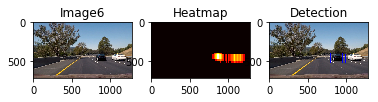

In [41]:
# # pipeline testing
f_img = plt.imread('./test_images/test6.jpg')
ret_img,heatmap = pipeline(f_img)
plt.subplot(1,3,1)
plt.title("Image6")
plt.imshow(f_img)
plt.subplot(1,3,2)
plt.title("Heatmap")
plt.imshow(heatmap,cmap = 'hot')
plt.subplot(1,3,3)
plt.title("Detection")
plt.imshow(ret_img)


Total windows 135


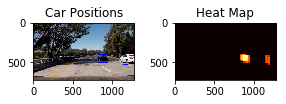

In [43]:
#---- for testing
from scipy.ndimage.measurements import label
frame_img = plt.imread('./test_images/test5.jpg')
# t1 = time.time()
windows = all_windows(frame_img)
print('Total windows',len(windows))
hot_window = search_window_obj(frame_img,svc,windows)
# print('Total matched windows',len(hot_window))
windows_img = draw_boxes(frame_img,hot_window)
plt.imsave('detected.jpg',windows_img)

heat = np.zeros_like(frame_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_window)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
# print(type(labels))

# to remove false positives
heat_thrshold = [30,30]
draw_img = draw_labeled_bboxes(np.copy(frame_img), labels ,heat_thrshold)
# print('time taken for one image :',time.time()-t1) #time taken for one image : 13.113383054733276

fig = plt.figure()
plt.subplot(131)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(132)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.imsave('car_position.jpg',draw_img)
plt.imsave('heatmap.jpg',heatmap)
plt.title('Heat Map')

In [18]:
# frame_img = plt.imread('./test_images/test4.jpg')
# frame_img = cv2.cvtColor(frame_img,cv2.COLOR_RGB2YUV)
# plt.imshow(frame_img[:,:,0])

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_output = './project_video_final.mp4'
clip1 = VideoFileClip("./project_video.mp4")
obj_clip = clip1.fl_image(pipeline)
%time obj_clip.write_videofile(video_output,audio = False)

0
[MoviePy] >>>> Building video ./project_video_final.mp4
[MoviePy] Writing video ./project_video_final.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

0


  0%|                                                                                 | 1/1261 [00:02<45:35,  2.17s/it]

0


  0%|▏                                                                                | 2/1261 [00:04<46:36,  2.22s/it]

0


  0%|▏                                                                                | 3/1261 [00:06<46:36,  2.22s/it]

0


  0%|▎                                                                                | 4/1261 [00:08<46:29,  2.22s/it]

0


  0%|▎                                                                                | 5/1261 [00:11<46:54,  2.24s/it]

0


  0%|▍                                                                                | 6/1261 [00:13<48:12,  2.30s/it]

0


  1%|▍                                                                                | 7/1261 [00:16<49:30,  2.37s/it]

0


  1%|▌                                                                                | 8/1261 [00:18<48:17,  2.31s/it]

0


  1%|▌                                                                                | 9/1261 [00:20<47:42,  2.29s/it]

0


  1%|▋                                                                               | 10/1261 [00:23<48:44,  2.34s/it]

0


  1%|▋                                                                               | 11/1261 [00:25<49:09,  2.36s/it]

0


  1%|▊                                                                               | 12/1261 [00:27<49:28,  2.38s/it]

0


  1%|▊                                                                               | 13/1261 [00:30<49:05,  2.36s/it]

0


  1%|▉                                                                               | 14/1261 [00:32<47:44,  2.30s/it]

0


  1%|▉                                                                               | 15/1261 [00:34<47:11,  2.27s/it]

0


  1%|█                                                                               | 16/1261 [00:37<48:18,  2.33s/it]

0


  1%|█                                                                               | 17/1261 [00:39<48:54,  2.36s/it]

0


  1%|█▏                                                                              | 18/1261 [00:41<49:32,  2.39s/it]

0


  2%|█▏                                                                              | 19/1261 [00:44<50:23,  2.43s/it]

0


  2%|█▎                                                                              | 20/1261 [00:46<48:49,  2.36s/it]

0


  2%|█▎                                                                              | 21/1261 [00:49<48:45,  2.36s/it]

0


  2%|█▍                                                                              | 22/1261 [00:51<48:23,  2.34s/it]

1


  2%|█▍                                                                              | 23/1261 [00:53<47:09,  2.29s/it]

0


  2%|█▌                                                                              | 24/1261 [00:55<46:13,  2.24s/it]

0


  2%|█▌                                                                              | 25/1261 [00:57<45:32,  2.21s/it]

2


  2%|█▋                                                                              | 26/1261 [01:00<46:16,  2.25s/it]

2


  2%|█▋                                                                              | 27/1261 [01:02<45:55,  2.23s/it]

1


  2%|█▊                                                                              | 28/1261 [01:04<46:44,  2.27s/it]

1


  2%|█▊                                                                              | 29/1261 [01:06<46:16,  2.25s/it]

0


  2%|█▉                                                                              | 30/1261 [01:09<46:01,  2.24s/it]

0


  2%|█▉                                                                              | 31/1261 [01:11<46:18,  2.26s/it]

0


  3%|██                                                                              | 32/1261 [01:13<45:16,  2.21s/it]

0


  3%|██                                                                              | 33/1261 [01:15<44:30,  2.17s/it]

0


  3%|██▏                                                                             | 34/1261 [01:17<45:40,  2.23s/it]

1


  3%|██▏                                                                             | 35/1261 [01:20<45:31,  2.23s/it]

1


  3%|██▎                                                                             | 36/1261 [01:22<45:21,  2.22s/it]

0


  3%|██▎                                                                             | 37/1261 [01:24<45:40,  2.24s/it]

0


  3%|██▍                                                                             | 38/1261 [01:26<45:14,  2.22s/it]

1


  3%|██▍                                                                             | 39/1261 [01:29<45:54,  2.25s/it]

3


  3%|██▌                                                                             | 40/1261 [01:31<45:59,  2.26s/it]

2


  3%|██▌                                                                             | 41/1261 [01:33<47:47,  2.35s/it]

0


  3%|██▋                                                                             | 42/1261 [01:36<51:20,  2.53s/it]

0


  3%|██▋                                                                             | 43/1261 [01:39<50:17,  2.48s/it]

0


  3%|██▊                                                                             | 44/1261 [01:41<48:23,  2.39s/it]

0


  4%|██▊                                                                             | 45/1261 [01:43<48:08,  2.38s/it]

0


  4%|██▉                                                                             | 46/1261 [01:46<47:09,  2.33s/it]

0


  4%|██▉                                                                             | 47/1261 [01:48<45:56,  2.27s/it]

0


  4%|███                                                                             | 48/1261 [01:50<45:17,  2.24s/it]

0


  4%|███                                                                             | 49/1261 [01:52<45:30,  2.25s/it]

0


  4%|███▏                                                                            | 50/1261 [01:54<45:00,  2.23s/it]

0


  4%|███▏                                                                            | 51/1261 [01:56<44:13,  2.19s/it]

0


  4%|███▎                                                                            | 52/1261 [01:59<46:24,  2.30s/it]

0


  4%|███▎                                                                            | 53/1261 [02:01<46:55,  2.33s/it]

0


  4%|███▍                                                                            | 54/1261 [02:04<47:59,  2.39s/it]

0


  4%|███▍                                                                            | 55/1261 [02:06<47:17,  2.35s/it]

0


  4%|███▌                                                                            | 56/1261 [02:09<49:17,  2.45s/it]

0


  5%|███▌                                                                            | 57/1261 [02:11<49:04,  2.45s/it]

0


  5%|███▋                                                                            | 58/1261 [02:14<48:53,  2.44s/it]

0


  5%|███▋                                                                            | 59/1261 [02:16<50:12,  2.51s/it]

0


  5%|███▊                                                                            | 60/1261 [02:19<51:08,  2.56s/it]

0


  5%|███▊                                                                            | 61/1261 [02:21<50:14,  2.51s/it]

0


  5%|███▉                                                                            | 62/1261 [02:24<50:12,  2.51s/it]

0


  5%|███▉                                                                            | 63/1261 [02:26<49:22,  2.47s/it]

0


  5%|████                                                                            | 64/1261 [02:28<47:02,  2.36s/it]

0


  5%|████                                                                            | 65/1261 [02:31<46:29,  2.33s/it]

0


  5%|████▏                                                                           | 66/1261 [02:33<47:56,  2.41s/it]

0


  5%|████▎                                                                           | 67/1261 [02:35<46:00,  2.31s/it]

0


  5%|████▎                                                                           | 68/1261 [02:38<46:04,  2.32s/it]

0


  5%|████▍                                                                           | 69/1261 [02:41<50:08,  2.52s/it]

0


  6%|████▍                                                                           | 70/1261 [02:43<50:42,  2.55s/it]

0


  6%|████▌                                                                           | 71/1261 [02:46<49:31,  2.50s/it]

0


  6%|████▌                                                                           | 72/1261 [02:48<49:45,  2.51s/it]

0


  6%|████▋                                                                           | 73/1261 [02:51<48:46,  2.46s/it]

0


  6%|████▋                                                                           | 74/1261 [02:53<47:41,  2.41s/it]

0


  6%|████▊                                                                           | 75/1261 [02:55<45:38,  2.31s/it]

0


  6%|████▊                                                                           | 76/1261 [02:57<45:49,  2.32s/it]

0


  6%|████▉                                                                           | 77/1261 [03:00<47:00,  2.38s/it]

0


  6%|████▉                                                                           | 78/1261 [03:02<46:42,  2.37s/it]

0


  6%|█████                                                                           | 79/1261 [03:05<46:48,  2.38s/it]

0


  6%|█████                                                                           | 80/1261 [03:07<47:49,  2.43s/it]

0


  6%|█████▏                                                                          | 81/1261 [03:10<47:47,  2.43s/it]

0


  7%|█████▏                                                                          | 82/1261 [03:12<46:10,  2.35s/it]

0


  7%|█████▎                                                                          | 83/1261 [03:14<47:52,  2.44s/it]

0


  7%|█████▎                                                                          | 84/1261 [03:17<46:50,  2.39s/it]

0


  7%|█████▍                                                                          | 85/1261 [03:19<45:10,  2.31s/it]

0


  7%|█████▍                                                                          | 86/1261 [03:21<44:29,  2.27s/it]

0


  7%|█████▌                                                                          | 87/1261 [03:23<44:18,  2.26s/it]

0


  7%|█████▌                                                                          | 88/1261 [03:26<45:52,  2.35s/it]

0


  7%|█████▋                                                                          | 89/1261 [03:28<47:03,  2.41s/it]

0


  7%|█████▋                                                                          | 90/1261 [03:31<48:17,  2.47s/it]

0


  7%|█████▊                                                                          | 91/1261 [03:33<47:17,  2.43s/it]

0


  7%|█████▊                                                                          | 92/1261 [03:35<45:26,  2.33s/it]

0


  7%|█████▉                                                                          | 93/1261 [03:38<45:01,  2.31s/it]

0


  7%|█████▉                                                                          | 94/1261 [03:40<44:11,  2.27s/it]

0


  8%|██████                                                                          | 95/1261 [03:42<43:24,  2.23s/it]

0


  8%|██████                                                                          | 96/1261 [03:44<43:02,  2.22s/it]

0


  8%|██████▏                                                                         | 97/1261 [03:47<44:24,  2.29s/it]

0


  8%|██████▏                                                                         | 98/1261 [03:49<43:55,  2.27s/it]

0


  8%|██████▎                                                                         | 99/1261 [03:51<44:44,  2.31s/it]

0


  8%|██████▎                                                                        | 100/1261 [03:54<45:15,  2.34s/it]

0


  8%|██████▎                                                                        | 101/1261 [03:56<44:34,  2.31s/it]

0


  8%|██████▍                                                                        | 102/1261 [03:58<44:08,  2.29s/it]

0


  8%|██████▍                                                                        | 103/1261 [04:01<45:44,  2.37s/it]

0


  8%|██████▌                                                                        | 104/1261 [04:03<46:11,  2.40s/it]

0


  8%|██████▌                                                                        | 105/1261 [04:05<45:15,  2.35s/it]

0


  8%|██████▋                                                                        | 106/1261 [04:07<44:00,  2.29s/it]

0


  8%|██████▋                                                                        | 107/1261 [04:10<46:21,  2.41s/it]

0


  9%|██████▊                                                                        | 108/1261 [04:12<45:42,  2.38s/it]

0


  9%|██████▊                                                                        | 109/1261 [04:15<44:52,  2.34s/it]

0


  9%|██████▉                                                                        | 110/1261 [04:17<44:26,  2.32s/it]

0


  9%|██████▉                                                                        | 111/1261 [04:19<45:44,  2.39s/it]

0


  9%|███████                                                                        | 112/1261 [04:22<44:20,  2.32s/it]

KeyboardInterrupt: 

In [20]:
print('hello')

hello
